In [16]:
using CSV
using DataFrames

# CSVファイルを読み込む
df = CSV.read("streaming.csv", DataFrame)

Row,DaysSinceLastActivity,HasActivePromotionalOffer,AverageSessionDuration,IsChurned
,Float64,Int64,Float64,Int64
1,3.98981,0,39.2601,0
2,10.9716,1,63.3856,0
3,11.5288,1,29.2988,0
4,0.321822,0,37.8862,0
5,9.85267,0,59.4333,0
6,14.8615,1,41.3992,0
7,44.6938,1,32.2437,1
8,3.13866,0,25.0432,0
9,10.0571,1,26.825,0


In [17]:
using LightGBM

# Separate features (X) and target (y)
X = Matrix(df[:, Not(:IsChurned)])
display(X)
y = df.IsChurned
display(y)

1000×3 Matrix{Float64}:
  3.98981   0.0  39.2601
 10.9716    1.0  63.3856
 11.5288    1.0  29.2988
  0.321822  0.0  37.8862
  9.85267   0.0  59.4333
 14.8615    1.0  41.3992
 44.6938    1.0  32.2437
  3.13866   0.0  25.0432
 10.0571    1.0  26.825
 16.6652    0.0  64.126
  ⋮              
  9.41387   0.0  50.2403
  1.12733   0.0  12.8268
 21.3714    1.0  16.3711
  4.44331   1.0  22.4858
 13.6163    1.0  16.0191
  3.62058   1.0  18.8062
  6.18547   0.0  20.4663
  9.68644   1.0  67.917
 12.5478    1.0   3.52226

1000-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [18]:
# Create LightGBM classifier
estimator = LGBMClassification(
    # 基本的なパラメータ
    objective = "binary",           # 二値分類タスクを指定
    num_iterations = 100,           # ブースティングの反復回数（木の数）
    learning_rate = 0.05,          # 学習率（各木の寄与度）
    num_class = 1,                 # クラス数（二値分類なので1）

    # 過学習制御パラメータ
    num_leaves = 31,               # 1つの木における最大葉ノード数
    max_depth = 6,                 # 木の最大深さ
    min_data_in_leaf = 20,        # 各葉に必要な最小データ数
    feature_fraction = 0.8,        # 各反復で使用する特徴量の割合
    bagging_fraction = 0.9,        # データのサブサンプリング割合
    bagging_freq = 1,             # バギングの頻度

    # 評価関連パラメータ
    metric = ["auc", "binary_logloss"],  # 評価指標
    early_stopping_round = 10,     # 性能改善が止まった時の早期停止

    # クラス不均衡対策
    scale_pos_weight = 9           # 正例の重み付け
)

# Train the model
fit!(estimator, X, y)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 100, number of negative: 900
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100000 -> initscore=-2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Dict{String, Any} with 2 entries:
  "metrics"   => Dict{String, Dict{String, Vector{Float64}}}()
  "best_iter" => 0

In [19]:
# Make predictions
y_pred = predict(estimator, X) # Predict probabilities

# Convert probabilities to binary predictions if needed
y_pred_binary = [p > 0.5 ? 1 : 0 for p in y_pred]

# Evaluate the model (example: accuracy)
accuracy = sum(y_pred_binary .== y) / length(y)
println("Accuracy: ", accuracy)

Accuracy: 0.926


In [20]:
# Get feature importance
# Option 1: Split importance (number of times features are used in splits)
importance_split = LightGBM.split_importance(estimator)

# Option 2: Gain importance (total gains of splits)
importance_gain = LightGBM.gain_importance(estimator)

# Or get both at once
importance = (
    split = LightGBM.split_importance(estimator),
    gain = LightGBM.gain_importance(estimator)
)

(split = [468.0, 138.0, 1159.0],
 gain = [11285.25046489579, 760.1471841270813, 4897.8169114071425],)

In [21]:
# 特徴量名を取得
feature_names = names(df[:, Not(:IsChurned)])

# 特徴量の重要度を可視化しやすい形式に変換
importance_df = DataFrame(
    feature = feature_names,
    split_importance = importance.split,
    gain_importance = importance.gain
)

# 結果を表示
println("Feature Importance:")
display(importance_df)

Row,feature,split_importance,gain_importance
,String,Float64,Float64
1,DaysSinceLastActivity,468.0,11285.3
2,HasActivePromotionalOffer,138.0,760.147
3,AverageSessionDuration,1159.0,4897.82


Feature Importance:


In [22]:
using MLJ

# 予測確率を取得
y_pred_proba = predict(estimator, X)
y_pred_binary = vec([p > 0.5 ? 1 : 0 for p in y_pred_proba])

# 次元を確認
println("y shape: ", size(y))
println("y_pred_binary shape: ", size(y_pred_binary))

# 混同行列
confusion_matrix = MLJ.confusion_matrix(y, y_pred_binary)
display(confusion_matrix)


          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  0   │  1   │
├─────────┼──────┼──────┤
│    0    │ 826  │  74  │
├─────────┼──────┼──────┤
│    1    │  0   │ 100  │
└─────────┴──────┴──────┘


y shape: (1000,)
y_pred_binary shape: (1000,)


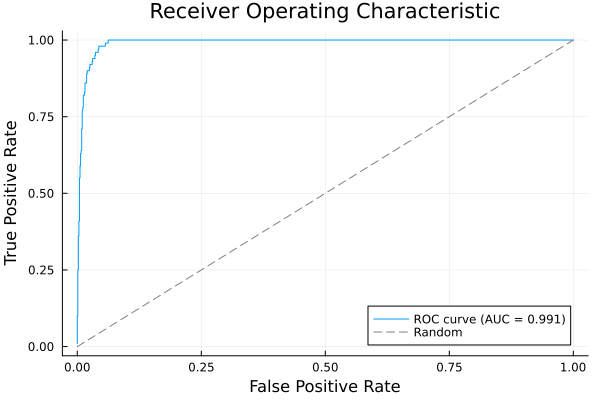

In [28]:
# ROC曲線とAUCの計算
using Plots
using MLJ

# ROC曲線のデータポイントを計算
function calculate_roc_points(y_true, y_scores)
    thresholds = sort(unique(y_scores), rev=true)
    tpr = Float64[]  # True Positive Rate
    fpr = Float64[]  # False Positive Rate
    
    for threshold in thresholds
        predictions = y_scores .>= threshold
        tp = sum(predictions .& (y_true .== 1))
        fp = sum(predictions .& (y_true .== 0))
        fn = sum(.!predictions .& (y_true .== 1))
        tn = sum(.!predictions .& (y_true .== 0))
        
        push!(tpr, tp / (tp + fn))
        push!(fpr, fp / (fp + tn))
    end
    
    # 終点(1,1)を追加
    push!(tpr, 1.0)
    push!(fpr, 1.0)
    
    return fpr, tpr
end

# AUCを計算
function calculate_auc(fpr, tpr)
    # 台形法でAUCを計算
    auc = 0.0
    for i in 1:length(fpr)-1
        auc += (fpr[i+1] - fpr[i]) * (tpr[i+1] + tpr[i]) / 2
    end
    return auc
end

# ROC曲線をプロット
fpr, tpr = calculate_roc_points(y, y_pred_proba)
auc = calculate_auc(fpr, tpr)

plot(fpr, tpr, 
     label="ROC curve (AUC = $(round(auc, digits=3)))",
     xlabel="False Positive Rate",
     ylabel="True Positive Rate",
     title="Receiver Operating Characteristic",
     legend=:bottomright)
plot!([0,1], [0,1], label="Random", linestyle=:dash, color=:gray)

In [33]:
# y_pred_probaをベクトルに変換
y_pred_proba_vec = vec(y_pred_proba)

# Convert y_pred_proba_vec to allow missing values
y_pred_proba_vec = allowmissing(y_pred_proba_vec)

# ROC曲線とAUCを計算
fprs, tprs, thresholds = roc(y_pred_proba_vec, y)
auc_score = auc(y_pred_proba_vec, y)

# プロット
using Plots
plot(fprs, tprs,
     label="ROC curve (AUC = $(round(auc_score, digits=3)))",
     xlabel="False Positive Rate",
     ylabel="True Positive Rate",
     title="Receiver Operating Characteristic")
plot!([0,1], [0,1], label="Random", linestyle=:dash, color=:gray)

MethodError: MethodError: no method matching remove_missing(::Vector{Int64})
The function `remove_missing` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  remove_missing(!Matched::AbstractArray{Union{Missing, T}, 1}) where T
   @ ROCAnalysis ~/.julia/packages/ROCAnalysis/wswCw/src/missing.jl:6
